In [1]:

from pinecone import Pinecone
from langchain_openai import OpenAIEmbeddings
import dotenv 
from langchain_pinecone import PineconeVectorStore


dotenv.load_dotenv()
index_name = "tax-index"
embeddings = OpenAIEmbeddings(model='text-embedding-3-large')
vectorstore = PineconeVectorStore(index_name=index_name, embedding=embeddings)
retriever = vectorstore.as_retriever(search_kwargs={'k':4})


C:\Users\soobi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import Annotated
from typing_extensions import List, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from langchain_core.documents import Document
import operator

class AgentState(TypedDict) :
    query:str
    context: List
    answer:str

In [3]:
#node:retrieve, generate 노트

def retrieveDoc(state:AgentState):
    query=state['query']
    docs =retriever.invoke(query)
    return {'context':docs}

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4o-mini')

In [5]:
from langsmith import Client

client = Client()
prompt = client.pull_prompt("rlm/rag-prompt")


def generateAnswer(state:AgentState):
    context= state['context']
    query= state['query']
    lag_chain = prompt | llm
    response = lag_chain.invoke({'question':query, 'context': context})

    return {'answer': response}

In [6]:
# Create a LangSmith API in Settings > API Keys
# Make sure API key env var is set:
# import os; os.environ["LANGSMITH_API_KEY"] = "<your-api-key>"
from langsmith import Client
from typing import Literal

client = Client()
doc_relevance_prompt = client.pull_prompt("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
   
    query = state['query']
    context = state['context']
    context_text = "\n\n".join([doc.page_content for doc in context])
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context_text})

    print(f'response: {response["Score"]}')
    if response['Score'] == 1:
        # 2.3장과 다르게 `relevant`와 `irrelevant`를 반환합니다
        # node를 직접 지정하는 것보다 실제 판단 결과를 리턴하면서 해당 node의 재사용성을 높일 수 있습니다.
        return 'relevant'
    
    return 'irrelevant'

In [7]:
pip install -U langchain-tavily

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: C:\Users\soobi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
from langchain_tavily import TavilySearch

tool = TavilySearch(
    max_results=5,
    topic="general",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
   
)


def web_search(state: AgentState) -> str:
    query = state['query']
    search_results = tool.invoke(query)
    return {'context': search_results}

In [9]:
from langgraph.graph import StateGraph

graph_builer = StateGraph(AgentState)

In [10]:
graph_builer.add_node('retrieve', retrieveDoc)
graph_builer.add_node('generate', generateAnswer)

graph_builer.add_node('web_search', web_search)

In [11]:
from langgraph.graph import START, END


graph_builer.add_edge(START, 'retrieve')
graph_builer.add_conditional_edges('retrieve', check_doc_relevance, {
    'relevant': 'generate',
    'irrelevant': 'web_search'
})
graph_builer.add_edge('generate', END)
graph_builer.add_edge('web_search', 'generate')


In [12]:
graph = graph_builer.compile()

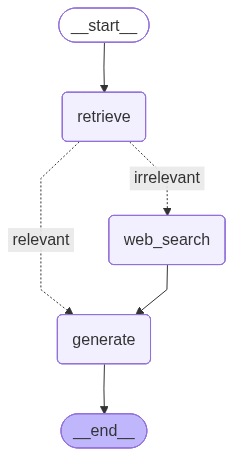

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_state = {'query': '연봉 5천만원인 직장인의 소득세는'}
graph.invoke(initial_state)

response: 1


{'query': '연봉 5천만원인 직장인의 소득세는',
 'context': [Document(id='5c70e245-c348-4e94-9e1d-494a929d69ad', metadata={'source': 'output_tax_income.txt'}, page_content='[p. 105]\n    * 바. 「국민연금법」에 따라 받는 반환일시금(사망으로 받는 것만 해당한다) 및 사망일시금\n    * 사. 「공무원연금법」, 「공무원 재해보상법」, 「군인연금법」, 「군인 재해보상법」, 「사립학교교직원 연금법」또는「별정우체국법」에 따라 받는 공무상요양비·요양급여ㆍ장해일시금ㆍ비공무상 장해일시금ㆍ비직무상 장해일시금ㆍ장애보상금ㆍ사망조위금ㆍ사망보상금ㆍ유족일시금·퇴직유족일시금ㆍ유족연금일시금·퇴직유족연금일시금ㆍ퇴역유족연금일시금ㆍ순직유족연금일시금ㆍ유족연금부가금·퇴직유족연금부가금ㆍ퇴역유족연금부가금ㆍ유족연금특별부가금·퇴직유족연금특별부가금ㆍ퇴역유족연금특별부가금ㆍ순직유족보상금ㆍ직무상유족보상금ㆍ위험직무순직유족보상금·재해부조금·재난부조금 또는 신체·정신상의 장해·질병으로 인한 휴직기간에 받는 급여\n    * 아. 대통령령으로 정하는 학자금\n    * 자. 대통령령으로 정하는 실비변상적(實費辨償的) 성질의 급여\n    * 차. 외국정부(외국의 지방자치단체와 연방국가인 외국의 지방정부를 포함한다. 이하 같다) 또는 대통령령으로 정하는 국제기관에서 근무하는 사람으로서 대통령령으로 정하는 사람이 받는 급여. 다만, 그 외국정부가 그 나라에서 근무하는 우리나라 공무원의 급여에 대하여 소득세를 과세하지 아니하는 경우만 해당한다.\n법제처\n106\n국가법령정보센터\n--- [Section: Page 121-137] ---\n```markdown\n[p. 121]\n소득세법\n제3절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) ① 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산

In [15]:
initial_state = {'query': '야당역 맛집을 추천해줘'}
graph.invoke(initial_state)

response: 0


{'query': '야당역 맛집을 추천해줘',
 'context': {'query': '야당역 맛집을 추천해줘',
  'response_time': 5.37,
  'follow_up_questions': None,
  'answer': '야당역 맛집으로 연막창, 라까냐 스페인음식점, 네이버 블로그 추천 육미향 운정, 빽돈 파주야당점이 있습니다.',
  'images': ['https://blogthumb.pstatic.net/MjAyNDAxMDhfMjU5/MDAxNzA0NjczOTczNTgz.Ui0J0Qf8XZdCuCyipcoppCvzhaekh2r-ZVffWliS1Vkg.AXCnK4PfTl9AJlbjEAWtuZpYdPko1kUdOju8q5LjiSkg.JPEG.ooooosol/20240106��131951.jpg?type=w2',
   'https://blogthumb.pstatic.net/MjAyMDA0MjVfMjU0/MDAxNTg3ODIzNDc1MTgz.HDxkQmSZ1d6vIBEAZONaIXKrMeEzd8g_CULxroffCtgg.tHaknwJ_me27nQcrrZl1RLYP7WCcLnz7rtdmhgKhXaIg.PNG.pjh731/image.png?type=w2',
   'https://blog.kakaocdn.net/dn/dkTs4D/btsycVq7ucm/mJC9YqYkbRZ5NB5ejZXWkk/img.jpg',
   'https://mblogthumb-phinf.pstatic.net/MjAyMjEwMDRfMTkx/MDAxNjY0ODM5NjU4MTcy.gSGafnBTF1X7ZB7kVT1gk2UYL6CyxiiNVzxnSHvPfYIg.hezPb9Qus_ekhmKB_bf-V2V5fcpa0PQkVztQqhlLUTgg.JPEG.jayyo78/20220826＿183746.jpg?type=w800',
   'https://mblogthumb-phinf.pstatic.net/MjAyMjEwMDRfMTk0/MDAxNjY0ODM5NjU4MDM2.-NAb88GNY016MZ6O